#Configurações iniciais e Carregamento dos dados

In [1]:
!pip install nltk
import pandas as pd
from google.colab import drive
import nltk
import gensim
import csv
from itertools import groupby
from gensim.similarities import WmdSimilarity
from gensim.models import Word2Vec

In [2]:
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/My Drive/dadosbiblia'  
os.chdir(workdir_path)

Mounted at /content/drive


In [3]:
df_versosbiblicos = pd.read_csv('versosBliblicosCompleto.csv')

#Análise inicial dos dados

In [4]:
df_versosbiblicos.shape

(31090, 8)

In [6]:
df_versosbiblicos.head()

,abbrev,name,group,author,testament,chapter,verse,text
0,gn,Gênesis,Pentateuco,Moisés,VT,1,1,No princípio Deus criou os céus e a terra.
1,gn,Gênesis,Pentateuco,Moisés,VT,1,2,Era a terra sem forma e vazia; trevas cobriam ...
2,gn,Gênesis,Pentateuco,Moisés,VT,1,3,"Disse Deus: ""Haja luz"", e houve luz."
3,gn,Gênesis,Pentateuco,Moisés,VT,1,4,"Deus viu que a luz era boa, e separou a luz da..."
4,gn,Gênesis,Pentateuco,Moisés,VT,1,5,"Deus chamou à luz dia, e às trevas chamou noit..."


In [7]:
#303 versículos com 81 caracteres
df_versosbiblicos.text.map(len).value_counts().head()

81    303
85    291
78    288
83    276
75    276
Name: text, dtype: int64

In [8]:
# Importação seaborn para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_palette('dark')
sns.set_context('talk')

%matplotlib inline

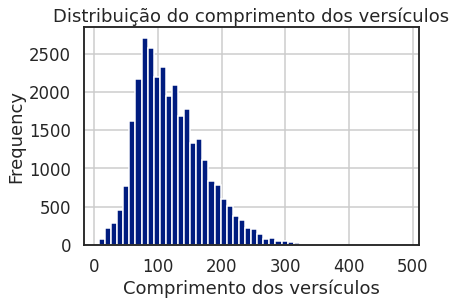

In [9]:
# Isso cria um histograma de todos os comprimentos dos versículos
ax = df_versosbiblicos.text.map(len).hist(bins=50)
ax.set(xlabel='Comprimento dos versículos', ylabel='Frequency', title='Distribuição do comprimento dos versículos');

In [10]:
df_versosbiblicos.iloc[1,7]


'Era a terra sem forma e vazia; trevas cobriam a face do abismo, e o Espírito de Deus se movia sobre a face das águas.'

# Etapa de pré-processamento

In [11]:
# Essa expressão regular remove toda a pontuação
import string
import re

punc_re = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
df_versosbiblicos['text'] = df_versosbiblicos.text.map(punc_re)

df_versosbiblicos.head()

,abbrev,name,group,author,testament,chapter,verse,text
0,gn,Gênesis,Pentateuco,Moisés,VT,1,1,No princípio Deus criou os céus e a terra
1,gn,Gênesis,Pentateuco,Moisés,VT,1,2,Era a terra sem forma e vazia trevas cobriam ...
2,gn,Gênesis,Pentateuco,Moisés,VT,1,3,Disse Deus Haja luz e houve luz
3,gn,Gênesis,Pentateuco,Moisés,VT,1,4,Deus viu que a luz era boa e separou a luz da...
4,gn,Gênesis,Pentateuco,Moisés,VT,1,5,Deus chamou à luz dia e às trevas chamou noit...


In [12]:
df_versosbiblicos.iloc[1,7]


'Era a terra sem forma e vazia  trevas cobriam a face do abismo  e o Espírito de Deus se movia sobre a face das águas '

In [13]:
# Essa expressão regular remove todas as palavras com números e também torna todas as palavras em minúsculas
import re

lower_alpha = lambda x: re.sub(r"""\w*\d\w*""", ' ', x.lower())
df_versosbiblicos['text'] = df_versosbiblicos.text.map(lower_alpha)

df_versosbiblicos.head()

,abbrev,name,group,author,testament,chapter,verse,text
0,gn,Gênesis,Pentateuco,Moisés,VT,1,1,no princípio deus criou os céus e a terra
1,gn,Gênesis,Pentateuco,Moisés,VT,1,2,era a terra sem forma e vazia trevas cobriam ...
2,gn,Gênesis,Pentateuco,Moisés,VT,1,3,disse deus haja luz e houve luz
3,gn,Gênesis,Pentateuco,Moisés,VT,1,4,deus viu que a luz era boa e separou a luz da...
4,gn,Gênesis,Pentateuco,Moisés,VT,1,5,deus chamou à luz dia e às trevas chamou noit...


In [14]:
df_versosbiblicos.iloc[1,7]

'era a terra sem forma e vazia  trevas cobriam a face do abismo  e o espírito de deus se movia sobre a face das águas '

In [15]:
# Tokenize os versículos em palavras
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


df_versosbiblicos['text'] = df_versosbiblicos.text.map(word_tokenize)
df_versosbiblicos.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,abbrev,name,group,author,testament,chapter,verse,text
0,gn,Gênesis,Pentateuco,Moisés,VT,1,1,"[no, princípio, deus, criou, os, céus, e, a, t..."
1,gn,Gênesis,Pentateuco,Moisés,VT,1,2,"[era, a, terra, sem, forma, e, vazia, trevas, ..."
2,gn,Gênesis,Pentateuco,Moisés,VT,1,3,"[disse, deus, haja, luz, e, houve, luz]"
3,gn,Gênesis,Pentateuco,Moisés,VT,1,4,"[deus, viu, que, a, luz, era, boa, e, separou,..."
4,gn,Gênesis,Pentateuco,Moisés,VT,1,5,"[deus, chamou, à, luz, dia, e, às, trevas, cha..."


In [16]:
# Isso cria uma lista enorme combinando todos os valores de tokens
word_list = sum(df_versosbiblicos.text.tolist(), [])

word_list[:10]

['no', 'princípio', 'deus', 'criou', 'os', 'céus', 'e', 'a', 'terra', 'era']

In [18]:
len(word_list)


686293

In [19]:
from collections import Counter

# Converte a lista em um dicionário com contagem de valores
word_counts = Counter(word_list)
a = word_counts

# Inverta a chave / valores no dicionário para classificar
word_counts = list(zip(word_counts.values(), word_counts.keys()))

# Classifique a lista por contagem
word_counts = sorted(word_counts, reverse=True)

# Imprime as 10 palavras mais comuns
word_counts[:10]

[(29106, 'e'),
 (27223, 'o'),
 (24789, 'de'),
 (20676, 'a'),
 (19614, 'que'),
 (14208, 'os'),
 (9974, 'do'),
 (8704, 'se'),
 (8566, 'para'),
 (7903, 'senhor')]

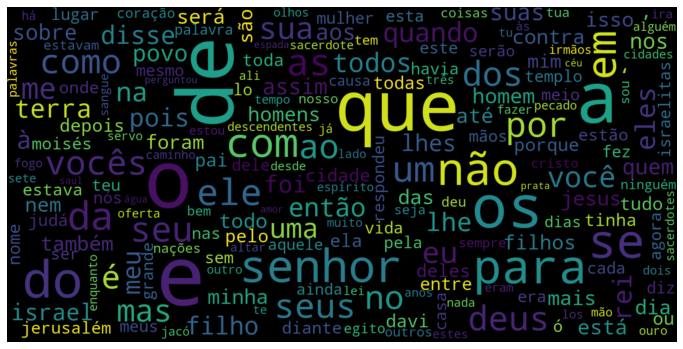

In [20]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = word_list
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).fit_words(a)
# wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

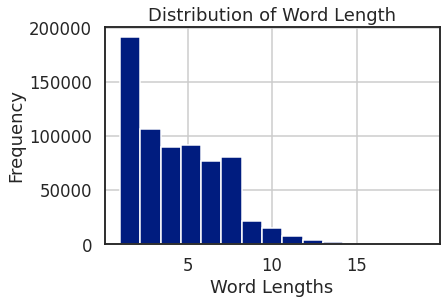

In [21]:
# A distribuição dos comprimentos das palavras
word_lengths = pd.Series([len(x) for x in word_list])

ax = word_lengths.hist(bins=15)
ax.set(xlabel='Word Lengths', ylabel='Frequency', title='Distribution of Word Length');

In [23]:
# Removendo as stop words
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = stopwords.words('portuguese')
stop_words = stop_words + [ '‘', '’','los', 'ó','lo','então']


stop_lambda = lambda x: [y for y in x if y not in stop_words]
df_versosbiblicos['tokens_stop'] = df_versosbiblicos.text.apply(stop_lambda)
df_versosbiblicos.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,abbrev,name,group,author,testament,chapter,verse,text,tokens_stop
0,gn,Gênesis,Pentateuco,Moisés,VT,1,1,"[no, princípio, deus, criou, os, céus, e, a, t...","[princípio, deus, criou, céus, terra]"
1,gn,Gênesis,Pentateuco,Moisés,VT,1,2,"[era, a, terra, sem, forma, e, vazia, trevas, ...","[terra, forma, vazia, trevas, cobriam, face, a..."
2,gn,Gênesis,Pentateuco,Moisés,VT,1,3,"[disse, deus, haja, luz, e, houve, luz]","[disse, deus, luz, luz]"
3,gn,Gênesis,Pentateuco,Moisés,VT,1,4,"[deus, viu, que, a, luz, era, boa, e, separou,...","[deus, viu, luz, boa, separou, luz, trevas]"
4,gn,Gênesis,Pentateuco,Moisés,VT,1,5,"[deus, chamou, à, luz, dia, e, às, trevas, cha...","[deus, chamou, luz, dia, trevas, chamou, noite..."


In [24]:
# Vamos encontrar as palavras mais comuns depois de limpar os dados

# Isso cria uma lista enorme combinando todos os valores de tokens
word_list_clean = sum(df_versosbiblicos.tokens_stop.tolist(), [])

word_list_clean[:10]


['princípio',
 'deus',
 'criou',
 'céus',
 'terra',
 'terra',
 'forma',
 'vazia',
 'trevas',
 'cobriam']

In [25]:
len(word_list_clean)


345057

In [26]:
from collections import Counter

# Converte a lista em um dicionário com contagem de valores
word_counts_clean = Counter(word_list_clean)
a = word_counts_clean

# Inverta a chave / valores no dicionário para classificar
word_counts_clean = list(zip(word_counts_clean.values(), word_counts_clean.keys()))

# Classifique a lista por contagem
word_counts_clean = sorted(word_counts_clean, reverse=True)

# Imprime as 10 palavras mais comuns
word_counts_clean[:10]

[(7903, 'senhor'),
 (4165, 'deus'),
 (2418, 'todos'),
 (2349, 'rei'),
 (2309, 'terra'),
 (2242, 'disse'),
 (2236, 'pois'),
 (2151, 'filho'),
 (1854, 'israel'),
 (1822, 'povo')]

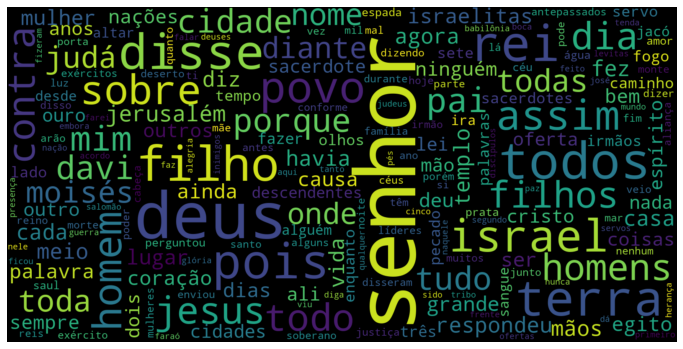

In [27]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = word_list_clean
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).fit_words(a)
# wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Criando Modelo Word2Vector

In [28]:
versiculos = df_versosbiblicos['tokens_stop']

In [30]:
type(versiculos[0])


list

In [31]:
# Treinamos Word2Vec com todos os versículos
model = Word2Vec(versiculos, workers=2, size=100)

# Salvar modelo em arquivo
model.save("bliblia-100.model")

# Calculamos a similaridade entre um conjunto de versículos
num_best = 10
instance = WmdSimilarity(versiculos[:1000], model, num_best=10)

In [32]:
def preprocess(sentence):
  return [word for word in sentence\
                if word not in stop_words and word.isalpha()]

In [33]:
text = 'senhor jesus'
sentence = nltk.word_tokenize(text.lower(), language='portuguese')
query = preprocess(sentence)
sims = instance[query]  # A query observa na classe de similaridade.

In [34]:
# Mostramos os resultado à da frase perguntada na celula anterior 
print('Query:')
print(text)
for i in range(num_best):
    print("")
    print('sim = %.4f' % sims[i][1])
    print(" ".join(versiculos[sims[i][0]]))

Query:
senhor jesus

sim = 0.7489
senhor disse esconderei abraão fazer

sim = 0.7258
respondeu abraão juro

sim = 0.7236
ló porém disse senhor

sim = 0.7230
disse servo abraão

sim = 0.7196
disse anjo senhor volte senhora sujeite

sim = 0.7152
orou senhor deus senhor abraão dá neste dia bom êxito bondoso senhor abraão

sim = 0.7150
curvei adoração senhor bendisse senhor deus senhor abraão guiou caminho certo buscar filho neta irmão senhor

sim = 0.7133
hoje cheguei fonte disse senhor deus senhor abraão assim desejares dá êxito missão incumbido

sim = 0.7113
senhor deus declarou bom homem farei alguém auxilie corresponda

sim = 0.7079
homem perguntou nome jacó respondeu


In [35]:
model.wv.most_similar('jesus')

[('vá', 0.9754983186721802),
 ('disse', 0.9704416990280151),
 ('perguntou', 0.9625344276428223),
 ('abraão', 0.9623802304267883),
 ('profeta', 0.9612890481948853),
 ('respondeu', 0.9580776691436768),
 ('davi', 0.9580352306365967),
 ('servo', 0.9554086923599243),
 ('sucederá', 0.9475816488265991),
 ('jacó', 0.9452586770057678)]

# Salvar Embeedings para Visualizar no Projector Embeedings

In [36]:

tensor_file = 'word_tensor.w2v'
model.wv.save_word2vec_format(tensor_file)
key_vectors = gensim.models.KeyedVectors.load_word2vec_format(tensor_file, binary=False)

In [37]:
words_id = []
vectors = []
for word_id in key_vectors.index2word[:10000]:
    words_id.append(word_id)
    vectors.append(key_vectors[word_id])

In [38]:
def create_tensorboard_files(tensor_filename, vectors, metadatos, colnames=None):

    out_file_tsv      = tensor_filename + '_tensor.tsv'
    out_file_tsv_meta = tensor_filename + '_metadata.tsv'
    
    with open(out_file_tsv, 'w',encoding='utf-8') as f:   
        for vector in vectors:
            vector_str = "\t".join([str(x) for x in vector])
            f.write( vector_str + '\n')

    with open(out_file_tsv_meta, 'w',encoding='utf-8') as f:
        writer = csv.writer(f, delimiter='\t')
        if len(metadatos)>=2:
            if colnames is None:
                colnames = "\t".join([str(i) for i in range(len(metadatos))])
            writer.writerow(colnames)
            for metadato in zip(*metadatos):
                line = [str(x) for x in metadato]
                writer.writerow(line)
        else:
            for metadato in metadatos[0]:
                writer.writerow([metadato])
            
    print("Arquivo com o Tensor 2D foi salvado em: %s" % out_file_tsv)
    print("Arquivo com o Tensor de metadatos foi salvado em: %s" % out_file_tsv_meta)

In [39]:
metadatos=[words_id]
create_tensorboard_files(tensor_filename="word", 
                      vectors=vectors, 
                      metadatos=[words_id])

Arquivo com o Tensor 2D foi salvado em: word_tensor.tsv
Arquivo com o Tensor de metadatos foi salvado em: word_metadata.tsv


# Aplicando Modelo Treinado

In [40]:
import numpy as np
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

#carrega um modelo pré-treinado (gloVe word vectors)
word_vectors = Word2Vec.load("bliblia-100.model")

# função de word -> vec
word2vec = lambda w: word_vectors.wv[w.lower()]

#função de similaridade
similarity = lambda x,y:cosine_similarity(x[np.newaxis,:],y[np.newaxis,:]).squeeze()

In [41]:
word_a, word_b = 'joão', 'pedro'
vec_a = word2vec(word_a) #transforma em word2vec
vec_b = word2vec(word_b) #transforma em word2vec

#calcula similaridade entre vec_a e vec_b
result = similarity(vec_a, vec_b).squeeze()
print("cosine_similarity( {} , {} ): {:.4f}".format(word_a,word_b,result))

cosine_similarity( joão , pedro ): 0.9950


In [42]:
word_a, word_b = 'senhor', 'deus'
vec_a = word2vec(word_a) #transforma em word2vec
vec_b = word2vec(word_b) #transforma em word2vec

#calcula similaridade entre vec_a e vec_b
result = similarity(vec_a, vec_b).squeeze()
print("cosine_similarity( {} , {} ): {:.4f}".format(word_a,word_b,result))

cosine_similarity( senhor , deus ): 0.9620


In [43]:
word_a, word_b = 'palavra', 'deus'
vec_a = word2vec(word_a) #transforma em word2vec
vec_b = word2vec(word_b) #transforma em word2vec

#calcula similaridade entre vec_a e vec_b
result = similarity(vec_a, vec_b).squeeze()
print("cosine_similarity( {} , {} ): {:.4f}".format(word_a,word_b,result))

cosine_similarity( palavra , deus ): 0.9420


In [44]:
word_a, word_b = 'maria', 'mãe'
vec_a = word2vec(word_a) #transforma em word2vec
vec_b = word2vec(word_b) #transforma em word2vec

#calcula similaridade entre vec_a e vec_b
result = similarity(vec_a, vec_b).squeeze()
print("cosine_similarity( {} , {} ): {:.4f}".format(word_a,word_b,result))

cosine_similarity( maria , mãe ): 0.8504


In [45]:
word_a, word_b = 'maria', 'pai'
vec_a = word2vec(word_a) #transforma em word2vec
vec_b = word2vec(word_b) #transforma em word2vec

#calcula similaridade entre vec_a e vec_b
result = similarity(vec_a, vec_b).squeeze()
print("cosine_similarity( {} , {} ): {:.4f}".format(word_a,word_b,result))

cosine_similarity( maria , pai ): 0.7636
